In [286]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [287]:
# インポート
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

print('numpy version:', np.__version__)
print('tensorflow version:', tf.__version__)
print('GPU:', tf.test.gpu_device_name())

numpy version: 1.17.3
tensorflow version: 1.15.0
GPU: /device:GPU:0


In [0]:
# データ読み込み関数
def loadData(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    speed = []
    xyzwave = []
    for row in data:
        speed.append(row[1].astype('f8'))
        xyzwave.append(row[2: 2 + 3 * 50].astype('f8'))
    speed = np.array(speed)
    x = np.array(xyzwave)
    t = speed[:, np.newaxis]
    return x, t

In [0]:
# 入力・教師データを対応させたままシャッフル
def shuffleData(x, t):
    zipped = list(zip(x, t))
    np.random.shuffle(zipped)
    x_result, t_result = zip(*zipped)
    return np.asarray(x_result), np.asarray(t_result)

In [0]:
# 学習データとテストデータに分割
def splitData(x, t):
    border = int(len(x) * 0.9)
    return (x[:border], t[:border]), (x[border:], t[border:])

In [0]:
# データの読み込み
x1, t1 = loadData('drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/data/ML/0912_1800.csv')
x2, t2 = loadData('drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/data/ML/0912_1815.csv')
x3, t3 = loadData('drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/data/ML/0925.csv')
x4, t4 = loadData('drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/data/ML/1010.csv')
x_all = np.concatenate([x1, x2, x3, x4], axis=0)
t_all = np.concatenate([t1, t2, t3, t4], axis=0)

x, t = loadData('drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/data/ML/1010.csv')

x_shuffle, t_shuffle = shuffleData(x, t)
(x_train, t_train), (x_test,  t_test) = splitData(x_shuffle, t_shuffle)

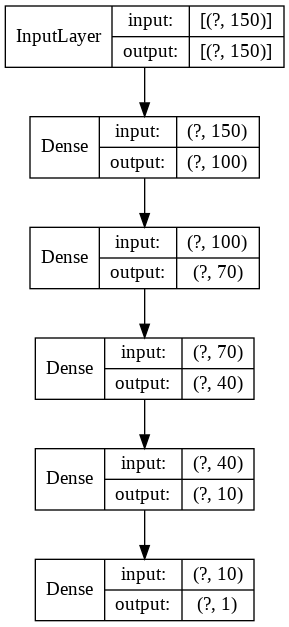

In [292]:
# モデル生成
model = keras.Sequential()
model.add(layers.Input(shape=(150,)))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense( 70, activation='tanh'))
model.add(layers.Dense( 40, activation='tanh'))
model.add(layers.Dense( 10, activation='tanh'))
model.add(layers.Dense(  1))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse')

# モデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='drive/My Drive/卒業研究/colab/graph/model.png',
           show_shapes=True, show_layer_names=False)

In [293]:
# モデルの訓練
result = model.fit(x_train, t_train, epochs=100)

Train on 1171 samples
Epoch 1/100
1171/1171 [==============================] - 1s 1ms/sample - loss: 1.0663
Epoch 2/100
1171/1171 [==============================] - 0s 120us/sample - loss: 0.1327
Epoch 3/100
1171/1171 [==============================] - 0s 121us/sample - loss: 0.0916
Epoch 4/100
1171/1171 [==============================] - 0s 130us/sample - loss: 0.0797
Epoch 5/100
1171/1171 [==============================] - 0s 122us/sample - loss: 0.0746
Epoch 6/100
1171/1171 [==============================] - 0s 118us/sample - loss: 0.0686
Epoch 7/100
1171/1171 [==============================] - 0s 135us/sample - loss: 0.0638
Epoch 8/100
1171/1171 [==============================] - 0s 129us/sample - loss: 0.0601
Epoch 9/100
1171/1171 [==============================] - 0s 122us/sample - loss: 0.0543
Epoch 10/100
1171/1171 [==============================] - 0s 140us/sample - loss: 0.0485
Epoch 11/100
1171/1171 [==============================] - 0s 122us/sample - loss: 0.0421
Epoch 12/1

In [0]:
# 学習データでテスト
y_train = model.predict(x_train)
error_train = np.abs(t_train - y_train)

# テストデータでテスト
y_test = model.predict(x_test)
error_test  = np.abs(t_test - y_test)

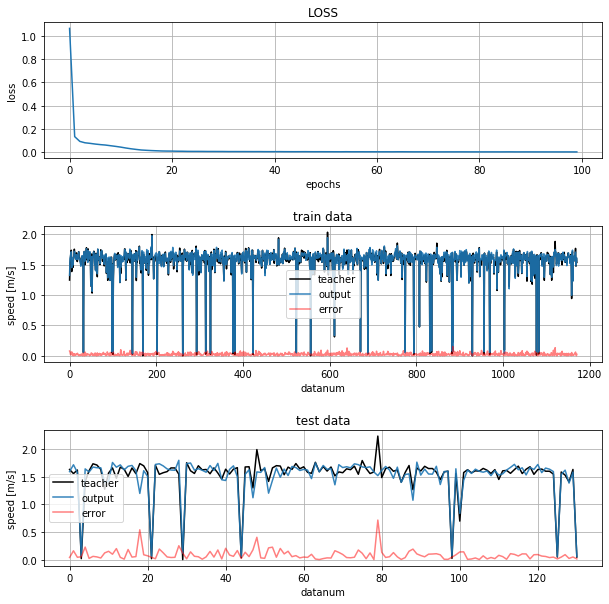

In [295]:
# グラフ表示
fig, axes = plt.subplots(3, 1, figsize=(10,10), facecolor="white")

axes[0].set_title('LOSS')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].plot(result.history['loss'], label="training")
axes[0].grid()

axes[1].set_title('train data')
axes[1].set_xlabel('datanum')
axes[1].set_ylabel('speed [m/s]')
axes[1].plot(t_train, color='black', label='teacher')
axes[1].plot(y_train, label='output', alpha=0.9)
axes[1].plot(error_train, color='red', label='error', alpha=0.5)
axes[1].legend()
axes[1].grid()

axes[2].set_title('test data')
axes[2].set_xlabel('datanum')
axes[2].set_ylabel('speed [m/s]')
axes[2].plot(t_test, color='black', label='teacher')
axes[2].plot(y_test, label='output', alpha=0.9)
axes[2].plot(error_test, color='red', label='error', alpha=0.5)
axes[2].legend()
axes[2].grid()

plt.subplots_adjust(hspace=0.5)
fig.show()
fig.savefig('drive/My Drive/卒業研究/colab/graph/graph.png')

In [296]:
error_train = np.abs(t_train - y_train)
error_test  = np.abs(t_test - y_test)

errorRate_train = np.average(error_train) / np.average(t_train) * 100
errorRate_test  = np.average(error_test ) / np.average(t_test) * 100
print('error_train_average = {} [%]'.format(errorRate_train))
print('error_test_average  = {} [%]'.format(errorRate_test))

error_train_average = 1.609923154165163 [%]
error_test_average  = 5.773154500429464 [%]
